# Feature Extraction VGG16

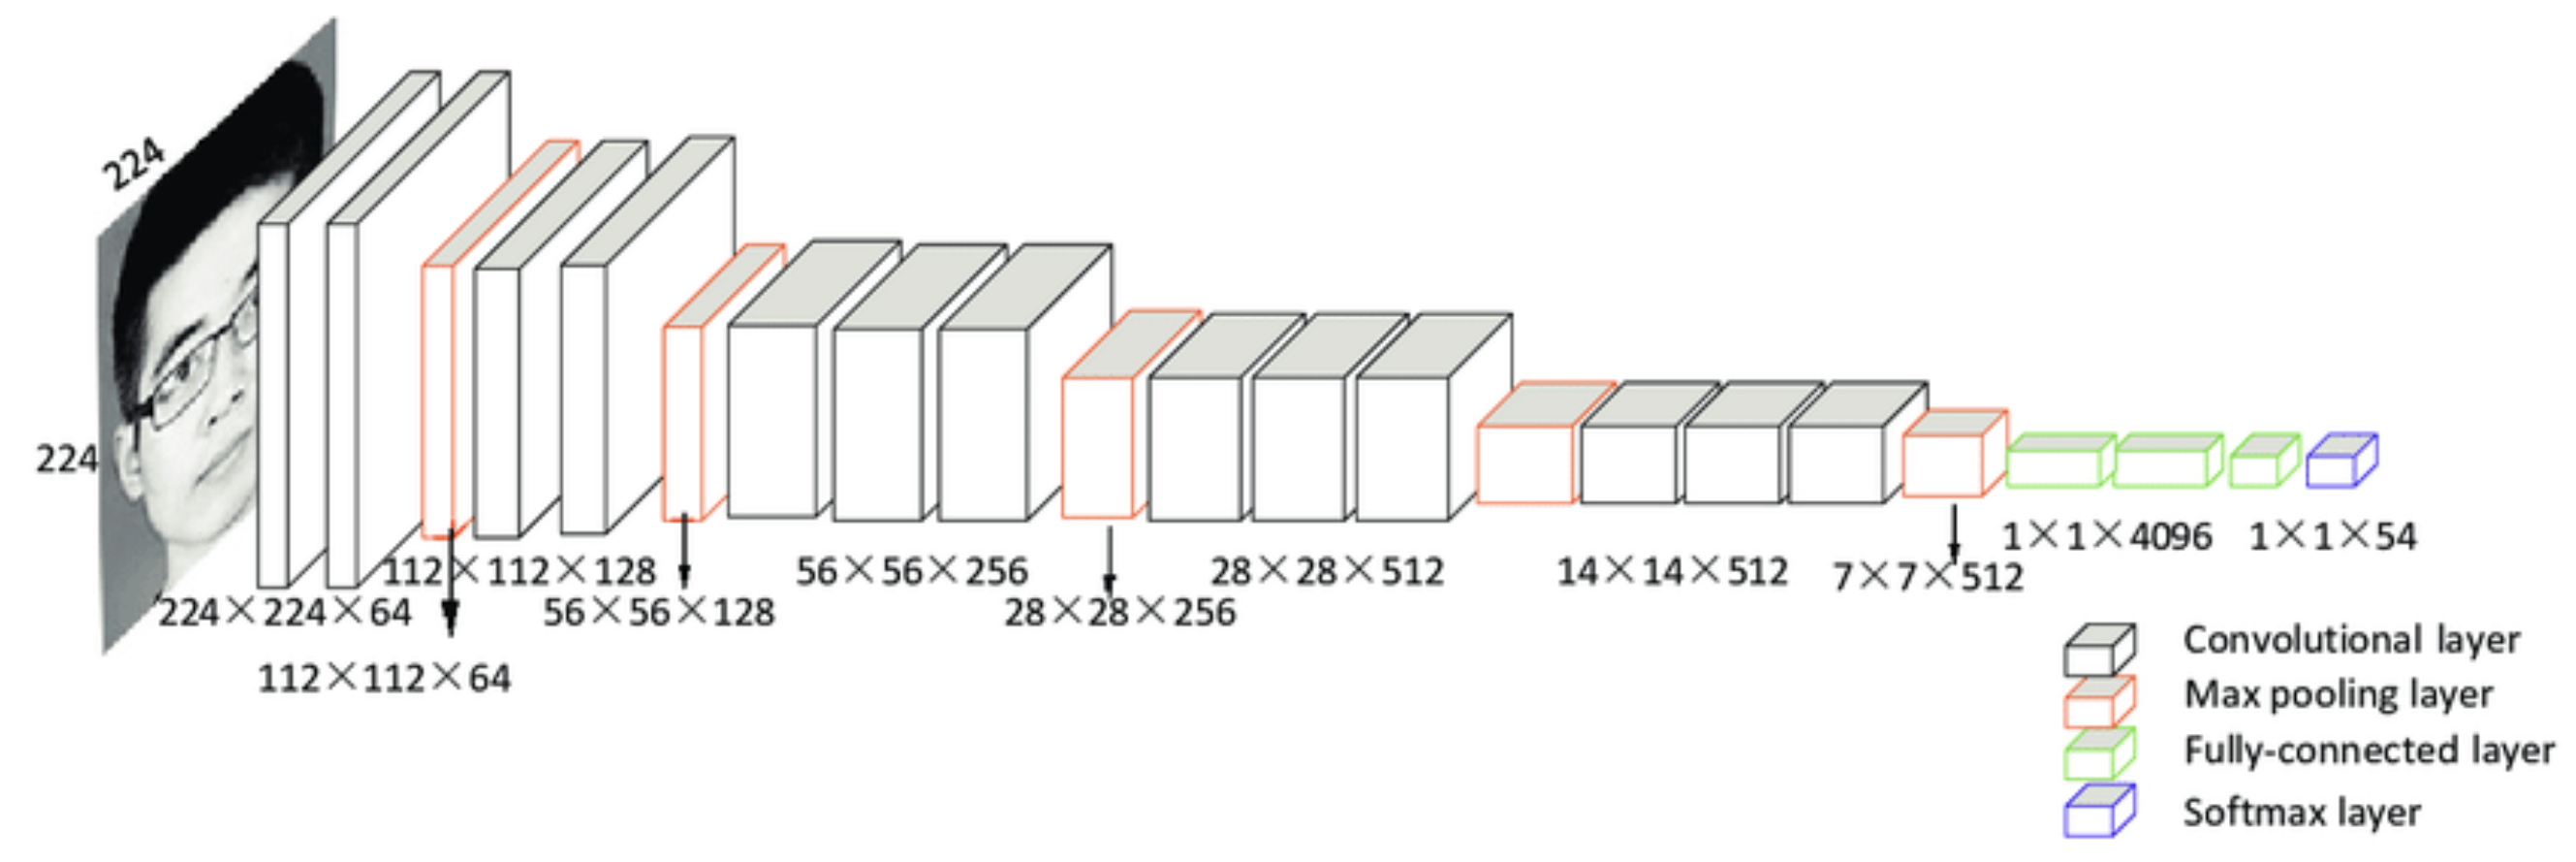

Pei, Zhao & Xu, Hang & Zhang, Yanning & Guo, Min & Yang, Yee-Hong. (2019). Face Recognition via Deep Learning Using Data Augmentation Based on Orthogonal Experiments. Electronics. 8. 1088. 10.3390/electronics8101088. 

## Data Loading

In [12]:
from src.preprocessing import CustomDataGenerator
from src.dataloader import read_train, read_val
X_train, y_train = read_train()
X_val, y_val = read_val()

## Network Extraction

Use keras to extract the network from the VGG16 model. The network is then saved to a file for later use.

In [13]:
import keras
from src import config

INPUT_SHAPE = (config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS)
model = keras.applications.VGG16(weights="imagenet", 
                                 include_top=False, 
                                 input_shape=INPUT_SHAPE)

In [14]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

## Add a classifier on top of the convolutional base

In [26]:
def add_classifier(model, ls_layers,
                   n_classes=config.N_CLASSES,
                   scale_orig=1/255.0):
    
    # Freeze the layers which you don't want to train. Here I am freezing the first 10 layers.
    model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS))

    scale_layer = keras.layers.Rescaling(scale=scale_orig)
    x = scale_layer(inputs)

    model_layers = model.layers[1:]

    for layer in model_layers + ls_layers:
        x = layer(x)

    outputs = keras.layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

ls_classifiers = [keras.layers.Flatten(),
                  keras.layers.Dense(1024, activation='relu'),
                  keras.layers.Dropout(0.3),
                  keras.layers.Dense(512, activation='relu'),]

model_clas = add_classifier(model, ls_classifiers)
model_clas.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584

## Train Model

In [27]:
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 10

train_generator = CustomDataGenerator(X_train, y_train, BATCH_SIZE)

In [28]:
model_clas = add_classifier(model, ls_classifiers)

# compile the model 
model_clas.compile(loss = "sparse_categorical_crossentropy", 
                    optimizer = keras.optimizers.legacy.Adam(lr=LEARNING_RATE), 
                    metrics=["accuracy"])

In [29]:
history = model_clas.fit(train_generator,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_val, y_val),
                            verbose=1)

Epoch 1/10
635/635 [==============================] - 76s 119ms/step - loss: 2.1324 - accuracy: 0.3725 - val_loss: 1.4923 - val_accuracy: 0.5262
Epoch 2/10
635/635 [==============================] - 76s 119ms/step - loss: 1.5492 - accuracy: 0.5072 - val_loss: 1.3392 - val_accuracy: 0.5800
Epoch 3/10
635/635 [==============================] - 76s 119ms/step - loss: 1.3105 - accuracy: 0.5681 - val_loss: 1.3035 - val_accuracy: 0.5614
Epoch 4/10
635/635 [==============================] - 76s 119ms/step - loss: 1.1903 - accuracy: 0.6089 - val_loss: 1.2067 - val_accuracy: 0.6014
Epoch 5/10
635/635 [==============================] - 76s 120ms/step - loss: 1.0473 - accuracy: 0.6536 - val_loss: 1.1321 - val_accuracy: 0.6324
Epoch 6/10
635/635 [==============================] - 76s 119ms/step - loss: 0.9632 - accuracy: 0.6780 - val_loss: 1.1344 - val_accuracy: 0.6303
Epoch 7/10
635/635 [==============================] - 75s 119ms/step - loss: 0.8988 - accuracy: 0.6989 - val_loss: 1.1150 - val_ac

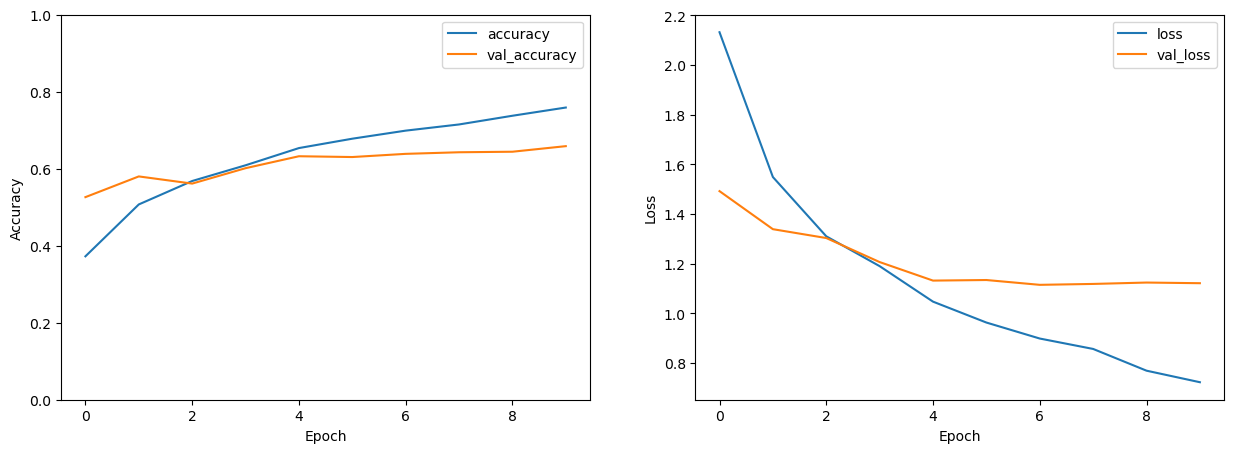

In [30]:
%reload_ext src.results
from src.results import plot_history
plot_history(model_clas);